In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import os
import cv2
import numpy as np
!pip install -U keras
!pip install tensorflow-gpu==2.1.0rc0

Requirement already up-to-date: keras in /usr/local/lib/python3.6/dist-packages (2.3.1)


In [0]:
# Function to convert image from greyscale to one hot (i.e. 3 channels)
def convertToOneHot(image):
    num_classes = 4
    shape = image.shape[:2]+(num_classes,)
    encoded_image = np.zeros(shape, dtype=np.uint8)
    for r in range(len(image)):
      for c in range(len(image[0])):
        if image[r][c]==0:
          encoded_image[r][c][0] = 1
        elif image[r][c]==85:
          encoded_image[r][c][1] = 1
        elif image[r][c]==170:
          encoded_image[r][c][2] = 1
        else:
          encoded_image[r][c][3] = 1
    return encoded_image

In [0]:
# Function to convert back from one hot image to greyscale
def convertFromOneHot(image):
    shape = image.shape[:2]
    encoded_image = np.zeros(shape, dtype=np.uint8)
    for r in range(len(image)):
      for c in range(len(image[0])):
        if image[r][c][0] == 1:
          encoded_image[r][c] = 0
        elif image[r][c][1] == 1:
          encoded_image[r][c] = 85
        elif image[r][c][2] == 1:
          encoded_image[r][c] = 170
        else:
          encoded_image[r][c] = 255
    return encoded_image

In [0]:
PATH = "/content/drive/My Drive/Breast Cancer Treatment/Numpy Arrays/4 Class PR"

# Train set patients: 230 232 239 242 
TrainX_1 = np.load(PATH + '/PR IHC 263 Images.npy')
TrainY_1 = np.load(PATH + '/PR IHC 263 Masks.npy')
TrainX_2 = np.load(PATH + '/PR IHC 232 Images.npy')
TrainY_2 = np.load(PATH + '/PR IHC 232 Masks.npy')
TrainX_3 = np.load(PATH + '/PR IHC 242 Images.npy')
TrainY_3 = np.load(PATH + '/PR IHC 242 Masks.npy')
TrainX_4 = np.load(PATH + '/PR IHC 230 Images.npy')
TrainY_4 = np.load(PATH + '/PR IHC 230 Masks.npy')

# Test set patients: 221 246 263
TestX_1 = np.load(PATH + '/PR IHC 221 Images.npy')
TestY_1 = np.load(PATH + '/PR IHC 221 Masks.npy')
TestX_2 = np.load(PATH + '/PR IHC 246 Images.npy')
TestY_2 = np.load(PATH + '/PR IHC 246 Masks.npy')
TestX_3 = np.load(PATH + '/PR IHC 239 Images.npy')
TestY_3 = np.load(PATH + '/PR IHC 239 Masks.npy')

In [0]:
TrainX = np.concatenate((TrainX_1, TrainX_2, TrainX_3, TrainX_4), axis=0)
TrainGroundTruth = np.concatenate((TrainY_1, TrainY_2, TrainY_3, TrainY_4), axis=0)
TrainY = []

for img in TrainGroundTruth:
  encoded_img = convertToOneHot(img)
  TrainY.append(encoded_img)

TrainY = np.asarray(TrainY)

TestX = np.concatenate((TestX_1, TestX_2, TestX_3), axis=0)
TestGroundTruth = np.concatenate((TestY_1, TestY_2, TestY_3), axis=0)
TestY = []

for img in TestGroundTruth:
  encoded_img = convertToOneHot(img)
  TestY.append(encoded_img)

TestY = np.asarray(TestY)

ValidX = TrainX[1800:, : ]
ValidY = TrainY[1800:, : ]

TrainX = TrainX[0:1800, : ]
TrainY = TrainY[0:1800, : ]

print(TrainX.shape)
print(TrainY.shape)
print(TestX.shape)
print(TestY.shape)
print(ValidX.shape)
print(ValidY.shape)

(1800, 240, 240, 3)
(1800, 240, 240, 4)
(1440, 240, 240, 3)
(1440, 240, 240, 4)
(312, 240, 240, 3)
(312, 240, 240, 4)


In [0]:
TrainX = np.reshape(TrainX,(-1,240, 240,3))
TrainY = np.reshape(TrainY,(-1,240, 240,4))

TrainX = TrainX.astype('float32')/255

TestX = np.reshape(TestX,(-1,240, 240,3))
TestY = np.reshape(TestY,(-1,240, 240,4))

TestX = TestX.astype('float32')/255

ValidX = np.reshape(ValidX,(-1,240, 240,3))
ValidY = np.reshape(ValidY,(-1,240, 240,4))

ValidX = ValidX.astype('float32')/255

In [0]:
print(TrainX.shape)
print(TrainY.shape)

print(TestX.shape)
print(TestY.shape)

print(ValidX.shape)
print(ValidY.shape)

(1800, 240, 240, 3)
(1800, 240, 240, 4)
(1440, 240, 240, 3)
(1440, 240, 240, 4)
(312, 240, 240, 3)
(312, 240, 240, 4)


In [0]:
!pip install medpy
from keras.layers import *
import keras
from keras.models import Sequential
import cv2
import os
import matplotlib.pyplot as plt
%matplotlib inline
from medpy.metric import dc, precision, recall
from keras import Model


Using TensorFlow backend.


In [0]:
def get_conv_block(input_layer,nFilters,size):
    conv1 = Conv2D(nFilters, size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(input_layer)
    bn1 = BatchNormalization()(conv1)
    conv2 = Conv2D(nFilters, size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(bn1)
    bn2 = BatchNormalization()(conv2)
    return bn2
    
def get_model():    
    input_layer = Input(shape=(240,240,3))
    block1 = get_conv_block(input_layer,32,3)
    mp1 = MaxPooling2D(pool_size=(2, 2))(block1)
    dr1 = Dropout(0.1)(mp1)
    
    block2 = get_conv_block(dr1,64,3)
    mp2 = MaxPooling2D(pool_size=(2, 2))(block2)
    dr2 = Dropout(0.1)(mp2)
    
    block3 = get_conv_block(dr2,128,3)
    mp3 = MaxPooling2D(pool_size=(2, 2))(block3)
    dr3 = Dropout(0.1)(mp3)
    
    block4 = get_conv_block(dr3,256,3)
    mp4 = MaxPooling2D(pool_size=(2, 2))(block4)
    dr4 = Dropout(0.1)(mp4)

    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(dr4)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)

    up1 = Conv2DTranspose(256,(3,3),strides =(2,2),activation='relu',padding='same',kernel_initializer = 'he_normal')(conv5)
    cat1 = concatenate([block4,up1])
    dr1 = Dropout(0.1)(cat1)
    block5 = get_conv_block(dr1,256,3)

    up2 = Conv2DTranspose(128,(3,3),strides =(2,2),activation='relu',padding='same',kernel_initializer = 'he_normal')(block5)
    cat2 = concatenate([block3,up2])
    dr2 = Dropout(0.1)(cat2)
    block6 = get_conv_block(dr2,128,3)
    
    up3 = Conv2DTranspose(64,(3,3),strides =(2,2),activation='relu',padding='same',kernel_initializer = 'he_normal')(block6)
    cat3 = concatenate([block2,up3])
    dr3 = Dropout(0.1)(cat3)
    block7 = get_conv_block(dr3,64,3)
    
    up4 = Conv2DTranspose(32,(3,3),strides =(2,2),activation='relu',padding='same',kernel_initializer = 'he_normal')(block7)
    cat4 = concatenate([block1,up4])
    dr4 = Dropout(0.1)(cat4)
    block8 = get_conv_block(dr4,64,3)

    conv10 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(block8)
    conv11 = Conv2D(4,(1,1), activation='softmax', padding = 'same')(conv10)

    model = Model(input_layer,conv11)
    return model

In [0]:
model = get_model()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 240, 240, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 240, 240, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 240, 240, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 240, 240, 32) 9248        batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [0]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)

In [0]:
import math
from keras.callbacks import EarlyStopping,ModelCheckpoint
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)
mc = ModelCheckpoint('Checkpoint.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [0]:
optimizer=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)

In [0]:
def tversky_loss(y_true, y_pred):
    alpha = 0.5
    beta  = 0.5
    
    ones = K.ones(K.shape(y_true))
    p0 = y_pred      # proba that voxels are class i
    p1 = ones-y_pred # proba that voxels are not class i
    g0 = y_true
    g1 = ones-y_true
    
    num = K.sum(p0*g0, (0,1,2))
    den = num + alpha*K.sum(p0*g1,(0,1,2)) + beta*K.sum(p1*g0,(0,1,2))
    
    T = K.sum(num/den) # when summing over classes, T has dynamic range [0 Ncl]
    
    Ncl = K.cast(K.shape(y_true)[-1], 'float32')
    return Ncl-T

def combined_loss(y_true, y_pred):
  return (1*K.categorical_crossentropy(y_true, y_pred))+(0.5*tversky_loss(y_true, y_pred))

In [0]:
import random
batch_size = 16
def get_batch(batch_size, X_train, Y_train): 
    size_batch = batch_size
    last_index = len(X_train) - 1
    x_train = X_train
    y_train = Y_train 
    while True:
        batch_data = [[],[]]
        for i in range(0, size_batch):
            random_index = random.randint(0, last_index)
            batch_data[0].append(x_train[random_index])
            batch_data[1].append(y_train[random_index])

        yield (np.array(batch_data[0]), np.array(batch_data[1]))     
        
datagen = get_batch(batch_size, TrainX, TrainY)

        

In [0]:
from keras import backend as K      
model.compile(loss=combined_loss, optimizer="adam", metrics=[dice_coef,'accuracy'])

In [0]:
from math import ceil
num_epoch = 100
MODELS_PATH = "/content/drive/My Drive/Breast Cancer Treatment/Models/4 Class/PR"
n_points = len(TrainX)
history = model.fit(datagen, 
                validation_data = (ValidX, ValidY),
                epochs=num_epoch,steps_per_epoch = ceil(n_points / batch_size), callbacks =[es,mc],  shuffle =True)
model.save(MODELS_PATH + '/4 Class_UNET_PR_13_04_2020.h5')

Epoch 1/100
113/113 [==============================] - 53s 465ms/step - loss: 1.4956 - dice_coef: 0.8941 - accuracy: 0.9508 - val_loss: 1.6550 - val_dice_coef: 0.9902 - val_accuracy: 0.9902

Epoch 00001: val_loss improved from inf to 1.65498, saving model to Checkpoint.h5
Epoch 2/100
113/113 [==============================] - 45s 396ms/step - loss: 1.3260 - dice_coef: 0.9558 - accuracy: 0.9661 - val_loss: 1.5788 - val_dice_coef: 0.9902 - val_accuracy: 0.9900

Epoch 00002: val_loss improved from 1.65498 to 1.57877, saving model to Checkpoint.h5
Epoch 3/100
113/113 [==============================] - 45s 396ms/step - loss: 1.2976 - dice_coef: 0.9601 - accuracy: 0.9641 - val_loss: 1.5632 - val_dice_coef: 0.9895 - val_accuracy: 0.9902

Epoch 00003: val_loss improved from 1.57877 to 1.56318, saving model to Checkpoint.h5
Epoch 4/100
113/113 [==============================] - 45s 396ms/step - loss: 1.3035 - dice_coef: 0.9577 - accuracy: 0.9622 - val_loss: 1.4640 - val_dice_coef: 0.9898 - val_

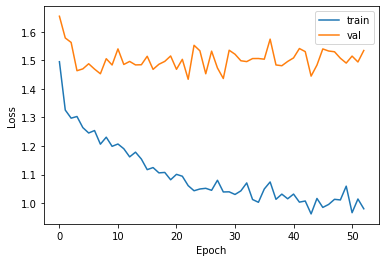

In [0]:
train_loss = history.history['loss']
train_acc = history.history['accuracy']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']
xc=range(len(train_loss))
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(xc, train_loss)
plt.plot(xc, val_loss)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(['train','val'])

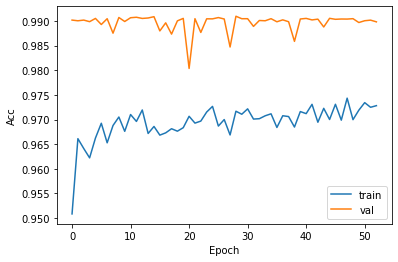

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(xc, train_acc)
plt.plot(xc, val_acc)
plt.xlabel("Epoch")
plt.ylabel("Acc")
plt.legend(['train','val'])

In [0]:
# MODELS_PATH = "/content/drive/My Drive/Breast Cancer Treatment/Models/4 Class/ER"
# model = keras.models.load_model(MODELS_PATH+'/4 Class_UNET_ER_08_04_2020v2.h5',custom_objects={ 'combined_loss': combined_loss, 'dice_coef': dice_coef })

In [0]:
# Function to find the most probable class of an image pixel by pixel
def ClassFinder(img):
  result = np.zeros(img.shape, dtype=np.uint8)
  for r in range(len(img)):
    for c in range(len(img[0])):
      idx = np.argmax(img[r][c])
      result[r][c][idx]=1
      
  return result    

In [0]:
TrainX = np.concatenate((TrainX,ValidX))
TrainY = np.concatenate((TrainY,ValidY))
train_result = model.predict(TrainX, batch_size=16)
print(np.shape(train_result))
Train_predict = [ ]
for img in train_result:
  img = ClassFinder(img)
  encoded_img = convertFromOneHot(img)
  Train_predict.append(encoded_img)

Predicted_images = np.asarray(Train_predict)
print(Predicted_images.shape)
np.unique(Predicted_images)
# dice = dc(train_result, TrainY)
# pre  = precision(train_result,TrainY)
# re   = recall(train_result,TrainY)
# print('Train dc: '  + str(dice))
# print('Train pre: ' + str(pre))
# print('Train re: '  + str(re))

(2112, 240, 240, 4)
(2112, 240, 240)


array([  0,  85, 170, 255], dtype=uint8)

In [0]:
test_result = model.predict(TestX, batch_size=16)
print(np.shape(test_result))

Test_predict = [ ]
for img in test_result:
  img = ClassFinder(img)
  encoded_img = convertFromOneHot(img)
  Test_predict.append(encoded_img)

Predicted_images_test = np.asarray(Test_predict)
print(Predicted_images_test.shape)
np.unique(Predicted_images_test)
# dice = dc(test_result, TestY)
# pre  = precision(test_result,TestY)
# re   = recall(test_result,TestY)
# print('Test dc: '  + str(dice))
# print('Test pre: ' + str(pre))
# print('Test re: '  + str(re))

(1440, 240, 240, 4)
(1440, 240, 240)


array([  0,  85, 170, 255], dtype=uint8)

In [0]:
from sklearn.metrics import confusion_matrix
def get_confusion_matrix(Actual, Predicted):
  ActualY = np.reshape(Actual,(-1, Actual.shape[3]))
  PredY = np.reshape(Predicted,(-1, Predicted.shape[3]))
  matrix = confusion_matrix(ActualY.argmax(axis = 1), PredY.argmax(axis = 1))
  return matrix

def get_precision(confusion_matrix):
  precision = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis = 0)
  nan_indices = np.isnan(precision)
  precision[nan_indices] = 0
  return precision

def get_recall(confusion_matrix):
  recall = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis = 1)
  nan_indices = np.isnan(recall)
  recall[nan_indices] = 0
  return recall


In [0]:
test_matrix = get_confusion_matrix(TestY, test_result)
train_matrix = get_confusion_matrix(TrainY, train_result)
print(test_matrix)
print(train_matrix)
# TestY.shape[3]
# test_result.shape

[[75170489   248870   346563  1517139]
 [  126285    50009    56950    47965]
 [  230647    24023   119011   930652]
 [   57738     4084    30742  3982833]]
[[116361835    796467    245785     46649]
 [   290190    902465    140007      2906]
 [   494454    363681    919977    261487]
 [    95124     41779    226358    462036]]


In [0]:
test_precision = get_precision(test_matrix)
print('Test Precision')
print(test_precision)
test_recall = get_recall(test_matrix)
print('Test Recall')
print(test_recall)
train_precision = get_precision(train_matrix)
print('Train Precision')
print(train_precision)
train_recall = get_recall(train_matrix)
print('Train Recall')
print(train_recall)

Test Precision
[0.99451387 0.15293927 0.2151063  0.61476859]
Test Recall
[0.97266449 0.1778357  0.0912428  0.97728712]
Train Precision
[0.99249611 0.42884833 0.6004574  0.59765767]
Train Recall
[0.99072887 0.67571625 0.45105778 0.55984209]


In [0]:
weight_matrix = np.zeros((4,1))
weight_matrix[0] = 1/3
weight_matrix[1] = 1/3
weight_matrix[2] = 1/3
weight_matrix[3] = 1/3
print(weight_matrix.shape)

(4, 1)


In [0]:
def get_overall_precision(precision, weights):
  final_precision = np.dot(precision,weights)
  return final_precision

def get_overall_recall(recall, weights):
  final_recall = np.dot(recall ,weights)
  return final_recall

In [0]:
final_test_precision  = get_overall_precision(test_precision, weight_matrix)
final_test_recall     = get_overall_recall(test_recall, weight_matrix)
final_train_precision = get_overall_precision(train_precision, weight_matrix)
final_train_recall    = get_overall_recall(train_recall, weight_matrix)
print('Final Test Precision')
print(final_test_precision)
print('Final Test Recall')
print(final_test_recall)
print('Final Train Precision')
print(final_train_precision)
print('Final Train Recall')
print(final_train_recall)

Final Test Precision
[0.65910934]
Final Test Recall
[0.73967671]
Final Train Precision
[0.87315317]
Final Train Recall
[0.89244833]


In [0]:
from scipy.stats import hmean

def dice_coefficient(precision, recall):
  return hmean(np.asarray([precision , recall]))
  

In [0]:
test_dice_coeff = dice_coefficient(final_test_precision, final_test_recall)
print('Test Dice coeff')
print(test_dice_coeff)

train_dice_coeff = dice_coefficient(final_train_precision, final_train_recall)
print('Train Dice coeff')
print(train_dice_coeff)

Test Dice coeff
[0.69707276]
Train Dice coeff
[0.88269532]


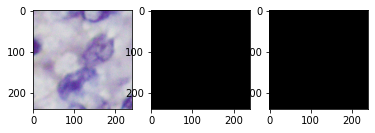

In [0]:
copy1  = np.copy(TestX [250])
copy2 = copy1.astype('float32')*255
copy2 = copy2.astype('uint8')
copy3 = np.reshape(copy2,(240, 240,3))
Img = cv2.cvtColor(copy3,cv2.COLOR_BGR2RGB)

Mask = TestGroundTruth[250]

Predicted_Mask = Predicted_images_test[250] 

plt.subplot(131).imshow(Img)
plt.subplot(132).imshow(Mask,'gray')
plt.subplot(133).imshow(Predicted_Mask,'gray')

In [0]:
def stitchMaskPatches(pieces):
  k = 0
  reconstructed_img = np.ones([1440,1920])
  for r in range(6):
    row = r * 240
    for c in range(8):
      col = c * 240
      reconstructed_img[row:row+240,col:col+240] = pieces[k]
      k = k + 1
  return reconstructed_img


def stitchImagePatches(pieces):
  k = 0
  reconstructed_img = np.ones([1440,1920,3])
  for r in range(6):
    row = r * 240
    for c in range(8):
      col = c * 240
      reconstructed_img[row:row+240,col:col+240,:] = pieces[k]
      k = k + 1
  return reconstructed_img


In [0]:


def saveNumpyOutput(mask):
  num = mask.shape[0]/480
  for id in range(int(num)):
    temp = []
    for i in range(id, id+10):
      idx = i * 48
      final_output = mask[idx:idx+48]
      final_output = stitchMaskPatches(final_output)
      temp.append(final_output)
    final_output = np.asarray(temp)
    np.save("/content/drive/My Drive/Breast Cancer Treatment/Numpy Arrays/Predicted Output/Combined_Loss/UNet 4 Class/ER1 Patient " + str(id), final_output)

In [0]:

# saving predicted outputs as numpy arrays for test images
saveNumpyOutput(Predicted_images)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


(48, 240, 240, 4)
(48, 240, 240)
(1440, 1920, 3)
(1440, 1920)
(1440, 1920)
[  0.  85. 170.]


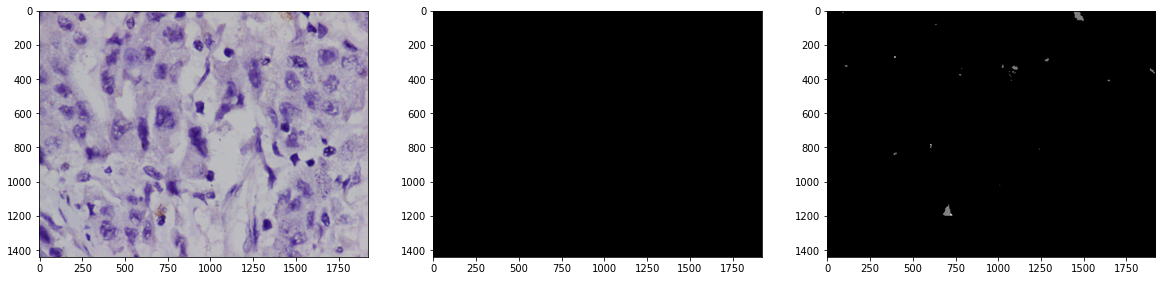

In [0]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow


plt.figure(figsize=(20,20))
id = 12   # enter between 0- 40 since there are 4 patients with 10 images each

id = id * 48
final_input = TestX[id:id+48]

Mask_input = TestY[id:id+48]
Test_Actual = [ ]
for img in Mask_input:
  img = ClassFinder(img)
  encoded_img = convertFromOneHot(img)
  Test_Actual.append(encoded_img)
  
print(Mask_input.shape)
Mask_input = np.asarray(Test_Actual)
print(Mask_input.shape)

final_output = Predicted_images_test[id:id+48]

final_input = stitchImagePatches(final_input)
Mask_input =  stitchMaskPatches(Mask_input)
final_output = stitchMaskPatches(final_output)

print(final_input.shape)
print(final_output.shape)
print(Mask_input.shape)

print(np.unique(final_output))
copy1  = np.copy(final_input)
copy2 = copy1.astype('float32')*255
copy2 = copy2.astype('uint8')
final_input = np.reshape(copy2,(1440, 1920,3))
final_input = cv2.cvtColor(final_input,cv2.COLOR_BGR2RGB)

plt.subplot(131).imshow(final_input)
plt.subplot(132).imshow(Mask_input,'gray')
plt.subplot(133).imshow(final_output,'gray')

(48, 240, 240, 4)
(48, 240, 240)
(1440, 1920, 3)
(1440, 1920)
(1440, 1920)
[  0.  85. 170. 255.]


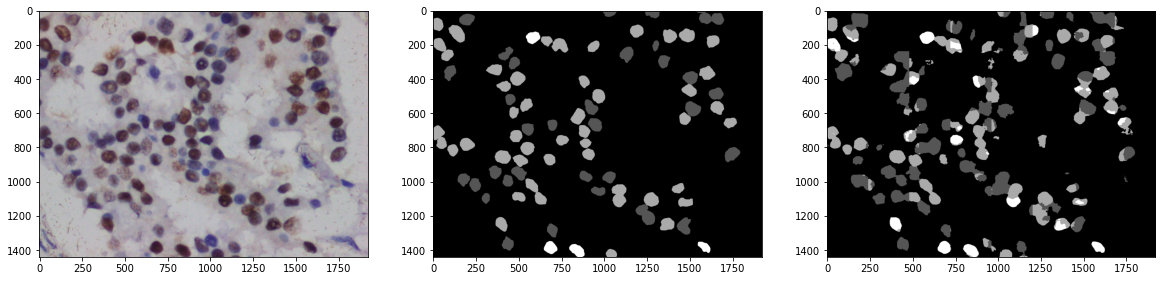

In [0]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow


plt.figure(figsize=(20,20))
id = 2  # enter between 0- 40 since there are 4 patients with 10 images each

id = id * 48
final_input = TrainX[id:id+48]

Mask_input = TrainY[id:id+48]
Train_Actual = [ ]
for img in Mask_input:
  img = ClassFinder(img)
  encoded_img = convertFromOneHot(img)
  Train_Actual.append(encoded_img)
  
print(Mask_input.shape)
Mask_input = np.asarray(Train_Actual)
print(Mask_input.shape)

final_output = Predicted_images[id:id+48]

final_input = stitchImagePatches(final_input)
Mask_input =  stitchMaskPatches(Mask_input)
final_output = stitchMaskPatches(final_output)

print(final_input.shape)
print(final_output.shape)
print(Mask_input.shape)

print(np.unique(final_output))
copy1  = np.copy(final_input)
copy2 = copy1.astype('float32')*255
copy2 = copy2.astype('uint8')
final_input = np.reshape(copy2,(1440, 1920,3))
final_input = cv2.cvtColor(final_input,cv2.COLOR_BGR2RGB)

plt.subplot(131).imshow(final_input)
plt.subplot(132).imshow(Mask_input,'gray')
plt.subplot(133).imshow(final_output,'gray')

In [0]:
SAVE_PATH = "/content/drive/My Drive/Breast Cancer Treatment/Predicted Images/ER/UNET/4 Class/8-04-2020"
def saveImageOutput(patients, GroundTruth, Predicted, folder):
  totalimages = patients * 10
  for id in range(totalimages):
    index = id * 48
    Mask_input = GroundTruth[index:index+48]
    GroundTruth_Actual = [ ]
    for img in Mask_input:
      img = ClassFinder(img)
      encoded_img = convertFromOneHot(img)
      GroundTruth_Actual.append(encoded_img)
    Mask_input = np.asarray(GroundTruth_Actual)
    final_output = Predicted[index:index+48]
    Mask_input   = stitchMaskPatches(Mask_input)
    final_output = stitchMaskPatches(final_output)
    cv2.imwrite(SAVE_PATH + '/Ground Truth' + folder + '/Image '+ str(id) + '.png', Mask_input)
    cv2.imwrite(SAVE_PATH +  '/Predicted Mask'+ folder + '/Image '+ str(id) + '.png', final_output)
    



In [0]:
saveImageOutput(3, TestY, Predicted_images_test, '/Test' )
saveImageOutput(4, TrainY, Predicted_images, '/Train' )